In [2]:
import yfinance as yf

start = "2019-01-01"
end   = "2020-03-20"
stocks = ["TSLA", "BTC-USD"]
keywords = {"TSLA": ["Tesla", "Elon Musk"],
            "BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

df_financial = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
df_financial = df_financial["Close"]

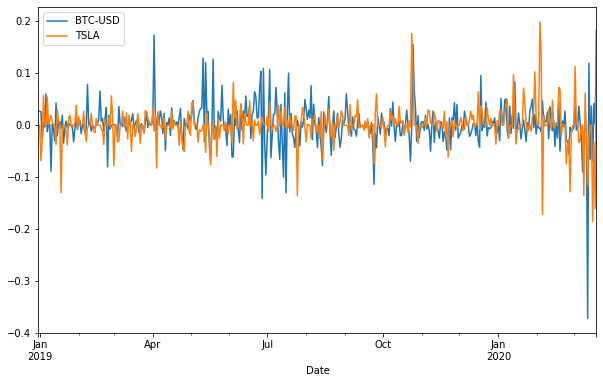

In [3]:
df_returns = df_financial.pct_change()
df_returns.plot(figsize = (10,6))

In [3]:
#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

In [4]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Using TensorFlow backend.
UsageError: Line magic function `%` not found.


In [ ]:
BertTokenizer.

In [ ]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

In [5]:
import ktrain
from ktrain import text
#https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/develop/examples/text/text_regression_example.ipynb

In [6]:
df_bitcoin = pd.read_csv("./csv/articles_Bitcoin-Cryptocurrency_start=2019-01-01_end=2020-12-31.csv", index_col = 0)
df_tesla = pd.read_csv("./csv/articles_Tesla-Elon_Musk_start=2019-01-01_end=2020-12-31.csv", index_col = 0)

In [7]:
df_bitcoin.head(2)

,authors,date_article,date_google,description,maintext,search_term,source_domain,title,url
0,NaN,2019-01-01,2019-01-01,Cryptocurrency exchange HitBTC has frozen its ...,Cryptocurrency exchange HitBTC has frozen its ...,Bitcoin | Cryptocurrency,www.ccn.com,HitBTC Freezes Customers' Accounts ahead of Pr...,https://www.ccn.com/bitcoin-exchange-hitbtc-fr...
1,"Lubomir Tassev,Lubomir Tassev Is A Journalist ...",2019-01-01,2019-01-01,Authorities in Abkhazia have cut off 15 mining...,Abkhazia Temporarily Shuts Down 15 Mining Farm...,Bitcoin | Cryptocurrency,news.bitcoin.com,Abkhazia Temporarily Shuts Down 15 Mining Farms,https://news.bitcoin.com/abkhazia-temporarily-...


In [8]:
from datetime import datetime, timedelta

In [9]:
def drop_articles_with_date_mismatch(df, threshold):
    diff_dt = pd.DataFrame()
    diff_dt["date_article"] = pd.to_datetime(df.date_article, format = "%Y-%m-%d", errors = "coerce")
    diff_dt["date_google"] = pd.to_datetime(df.date_google, format = "%Y-%m-%d", errors = "coerce")
    diff_dt["diff"] = diff_dt["date_article"] - diff_dt["date_google"]
    weird = diff_dt[diff_dt["diff"] > timedelta(threshold)].index
    normal = df.index.drop(weird)
    return df.iloc[weird], df.iloc[normal]
    

In [10]:
df_bitcoin_weird, df_bitcoin_normal = drop_articles_with_date_mismatch(df_bitcoin, 1)
df_group = df_bitcoin_normal[[ "date_google", "maintext"]].groupby("date_google").sum()
df_bitcoin_processed = pd.DataFrame(df_group.values.reshape(-1), index = df_group.index, columns = ["maintext"])

In [11]:
df_bitcoin_processed.head()

,maintext
date_google,
2019-01-01,Cryptocurrency exchange HitBTC has frozen its ...
2019-01-02,"Back in December 2017, when its price reached ..."
2019-01-03,Do your bitcoins really exist?\nThe answer mig...
2019-01-04,Renowned investor Gary Shilling believes Bitco...
2019-01-05,Coinbase and Its Troubling History of Customer...


In [12]:
df_returns.head()

,BTC-USD,TSLA
Date,,
2018-12-31,NaN,NaN
2019-01-01,0.026938,0.000000
2019-01-02,0.025989,-0.068149
2019-01-03,-0.027050,-0.031472
2019-01-04,0.005467,0.057697


In [13]:
start_date = '2019-01-01'
split_date = '2019-12-31'
end_date  =  '2020-03-19'
x_train = df_bitcoin_processed[start_date:split_date].values
y_train = df_returns["BTC-USD"][start_date:split_date].values
x_test = df_bitcoin_processed[split_date:end_date].values
y_test = df_returns[split_date:end_date]["BTC-USD"].values

In [15]:
x_train = df_bitcoin_processed[start_date:split_date]
y_train = df_returns.loc[pd.DatetimeIndex(x_train.index)]["BTC-USD"]
x_test = df_bitcoin_processed[split_date:end_date]
y_test = df_returns.loc[pd.DatetimeIndex(x_test.index)]["BTC-USD"]
print(len(x_train),len(x_test),len(y_train), len(y_test))

364 79 364 79


In [16]:
x_train = x_train.values.reshape(-1).tolist()
y_train = y_train.values.tolist()
x_test = x_test.values.reshape(-1).tolist()
y_test = y_test.values.tolist()

In [17]:
long_text = x_train[0]
words = long_text.replace("\n"," ").split(" ")
chuncks = [data[x:x+100] for x in range(0, len(data), 100)]

In [19]:
type(long_text)

str

In [32]:
import nltk.data
def split_in_sentences(texts, labels):  
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    all_sentences = []
    all_labels = []
    for text, ret in zip(texts, labels):
        sentences = tokenizer.tokenize(text)
        ret_many = [ret for i in range(len(sentences))]
        all_labels.extend(ret_many)
        all_sentences.extend(sentences)
    return all_sentences, all_labels

In [33]:
x_train_sentences ,y_train_sentences = split_in_sentences(x_train,y_train)
x_test_sentences ,y_test_sentences = split_in_sentences(x_train,y_train)

In [26]:
length = [len(s) for s in sentences]

In [ ]:
for long_text, r in zip(x_train[:2],y_train[:1]):
    words = long_text.replace("\n"," ").split(" ")
    [r, for i in range(len(words))]
    

In [83]:
min(length)

905

In [80]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [89]:
trn, val, preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                          x_test=x_test, y_test=y_test,
                                          ngram_range=3, 
                                          maxlen=512, 
                                          max_features=35000,
                                          preprocess_mode='bert')

task: text regression (supply class_names argument if this is supposed to be classification task)
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [85]:
text.print_text_regression_models()


fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
linreg: linear text regression using a trainable Embedding layer
bigru: Bidirectional GRU with pretrained word vectors [https://arxiv.org/abs/1712.09405]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face [https://arxiv.org/abs/1910.01108]


In [90]:
model = text.text_regression_model('bert', train_data=trn, preproc=preproc)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=256)

maxlen is 512
done.


/Users/juanluisrto/anaconda3/envs/tfm/lib/python3.7/site-packages/ktrain/__init__.py:87: UserWarning: For a GPU with 12GB of RAM, the following maxima apply:
        sequence len=64, max_batch_size=64
        sequence len=128, max_batch_size=32
        sequence len=256, max_batch_size=16
        sequence len=320, max_batch_size=14
        sequence len=384, max_batch_size=12
        sequence len=512, max_batch_size=6
        
        You've exceeded these limits.
        If using a GPU with <=12GB of memory, you may run out of memory during training.
        If necessary, adjust sequence length or batch size based on above.
  if wrn: warnings.warn(msg)


In [ ]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...


/Users/juanluisrto/anaconda3/envs/tfm/lib/python3.7/site-packages/ktrain/core.py:452: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  warnings.warn('max_epochs is being set to 5 since steps per epoch is small. ' +\


Train on 364 samples
Epoch 1/5
